Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\joun\AppData\Local\Temp\jieba.cache
Loading model cost 0.610 seconds.
Prefix dict has been built successfully.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3023/3023 [00:00<00:00, 5426.08it/s]


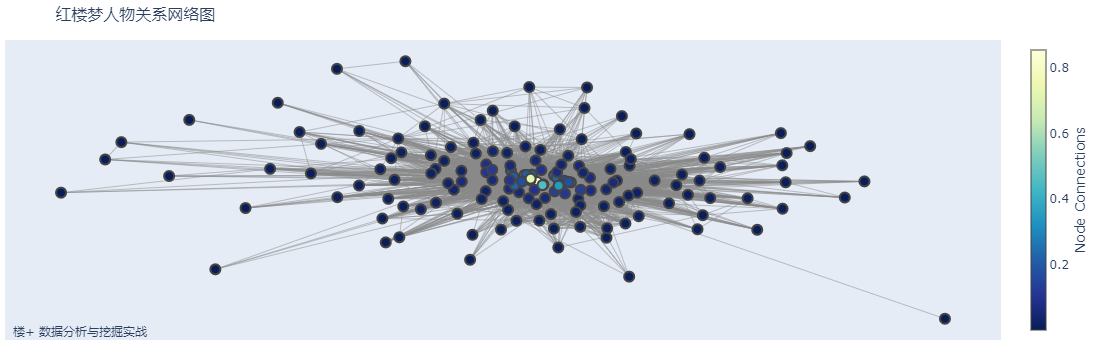

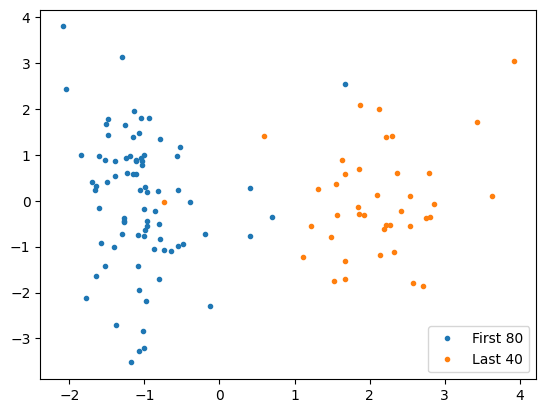

In [1]:
import re
import jieba
import json
from tqdm import tqdm
import os
import itertools
import numpy as np
from sklearn import decomposition
import matplotlib.pyplot as plt



# 加载别名表
file_path = 'userdict.json'
with open(file_path, 'r', encoding='utf-8') as f:  # 替换为正确的编码方式
    names = json.load(f)
for name in names:
    for alias_name in names[name]:
        # 结巴分词可以动态加载词语，在这里加载人物别名，以免错误的分词
        # nr 在结巴分词中代表人名
        jieba.add_word(alias_name, tag="nr")

def load_stopwords(file_path):
    # 加载停用词函数
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = [line.strip('\n') for line in f.readlines()]
    return stopwords

def process(file_path):
    # 对一个章节进行分词
    stopwords = load_stopwords('stopwords.txt')
    with open(file_path, 'rb') as f:
        content = f.read()
        para = content.decode("utf-8", 'ignore').split('\n')
        para = para[:-1]
        result = []
        for p in para:
            words = []
            # 对每一个段落进行分词
            seg_list = list(jieba.cut(p, cut_all=False))
            for x in seg_list:
                if len(x) <= 1:
                    continue
                if x in stopwords:
                    continue
                words.append(x)
            # 返回的是一个二维 list: [[段1结果], [段2结果], ]
            result.append(words)
    return result

result = {}

# 遍历目录
for file_name in tqdm(os.listdir('红楼梦')):
    # 获取章节的坐标，前面爬取的数据，是以 1_章节名 命名
    index = int(file_name.split('_')[0])
    # 分词，保存到一个字典，章节坐标对应分词结果
    result[index] = process(os.path.join('红楼梦', file_name))

#词频统计----------------------------------------

artical_word_dict = {}  # 整篇文章分词结果
chapters_word_dict = {}  # 每个章节的分词结果，对应到文章索引

# 遍历上文的分词结果
for index in tqdm(result):
    # 将一个章节的二维 list 压缩为一维，方便遍历
    chapter_word_list = list(itertools.chain.from_iterable(result[index]))
    chapter_word_dict = {}
    # 遍历
    for word in chapter_word_list:
        # 当词语不存在时 dict 初始化为 0
        if word not in chapter_word_dict:
            chapter_word_dict[word] = 0
        # 当词语不存在时 dict 初始化为 0
        if word not in artical_word_dict:
            artical_word_dict[word] = 0
        # 相应结果加一
        chapter_word_dict[word] += 1
        artical_word_dict[word] += 1
    chapters_word_dict[index] = chapter_word_dict

# 对整篇文章的词频统计结果进行排序，由高到低
sorted_word_list = [x[1] for x in sorted(
    zip(artical_word_dict.values(), artical_word_dict.keys()), reverse=True)]
sorted_word_list

#数据分析及可视化----------------------------
#分析是否为曹雪芹所作

all_names = []  # 所有名字的 list
for name in names:
    for alias_name in names[name]:
        all_names.append(alias_name)

# 待删除的名字
to_delete = []
for x in tqdm(sorted_word_list):
    for name in all_names:
        # 利用正则表达式判断一个词语是否是名字
        pattern = re.compile("(.*){}(.*)".format(name))
        # 正则查找匹配，如果匹配的结果不为 None 则该词语为名字
        t = re.search(pattern, x)
        # 如果一个词语是名字，则删除掉
        if t:
            to_delete.append(x)
            break

# 删除操作
for x in to_delete:
    sorted_word_list.remove(x)

V = 2000  # 选择前 V 个词语的词频作为一章节的特征
word_list = sorted_word_list[:V]
word_list



# 在这里生成一个 120*2000 的 0 矩阵，每一行对应一章节的特征。
features = np.zeros((len(chapters_word_dict), V))
# 遍历每个章节的 word dict
for index in chapters_word_dict:
    # 章节 word dict
    chapter_word_dict = chapters_word_dict[index]
    # 遍历每个词语，并改变相应位置的值为该词语出现次数
    for j, word in enumerate(word_list):
        try:
            features[index, j] = chapter_word_dict[word]
        except:
            # 该章节未出现这个词语
            pass
features.shape, features

features /= features.max(axis=0)  # 按列归一化到 [0, 1]
features.shape, features




# 特征降维
features = decomposition.PCA(n_components=2).fit_transform(features)

# 绘制前八十回和后四十回散点图
plt.plot(features[:80, 0].flatten(), features[:80, 1].flatten(), '.')
plt.plot(features[80:, 0].flatten(), features[80:, 1].flatten(), '.')
plt.legend(['First 80', 'Last 40'])



#人物关系绘制--------------
# 统计一起出现的次数
count = {}
for comb in itertools.product(names.keys(), repeat=2):
    count['_'.join(comb)] = 0

# 遍历章节词语
for para_word_list in tqdm(list(itertools.chain.from_iterable(result.values()))):
    para_name_list = []
    for name in names:
        tmp = set(names[name]).intersection(para_word_list)
        if len(tmp)>0:
            para_name_list.append(name)
    # 去重
    para_name_list = list(set(para_name_list))
    # 统计一段中共同出现的次数
    for comb in itertools.combinations(para_name_list, 2):
        count['_'.join(comb)] += 1
        

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
import networkx as nx
# 激活 Plotly notebook 模式，方便离线绘图
init_notebook_mode(connected=True)
G = nx.Graph()  # 创建 Graph
nodes = []  # 所有节点
edges = []  # 所有边
# 统计所有名字的组合
for comb in itertools.combinations(names.keys(), 2):
 #Number of times two names appear together
全部的=计数 [ &#39;{}_ {}&#39; .格式 (梳子 [ zero ] ,梳子 [ one ] ) ]+ \
计数 [ &#39;{}_ {}&#39; .格式 (梳子 [ one ] ,梳子 [ zero ] ) ]
 #If they appear together, save them
如果全部的 &#62; zero :
边缘 .追加 ( (梳子 [ zero ] ,梳子 [ one ] , {“重量”：总计 } ) )
节点 .追加 (梳子 [ zero ] )
节点 .追加 (梳子 [ one ] )

节点=列表 (设置 (节点 ) ) #Remove duplicate nodes
G公司 .添加节点来自 (节点 ) #Add nodes and edges
G公司 .添加源项（_E） (边缘 )

 #Nodes correspond to coordinates (x, y) on the graph
销售时点情报系统= nx（纳克斯） .春季布局 (G公司 )
销售时点情报系统

 #Draw the track of an edge
边缘_痕迹=去 .分散 (x个= [ ] ,年= [ ] ,线= 字典 (
宽度= zero point five ,颜色= &#39;#888&#39; ) , 悬停信息=“无” ,模式=&#39;行&#39; )

 #Traverse each edge and connect two nodes according to the coordinates of each node obtained above
对于边缘在里面G公司 .边缘 ( ) :
x0个 ,年=销售时点情报系统 [边缘 [ zero ] ]
x1个 ,y1个=销售时点情报系统 [边缘 [ one ] ]
边缘_痕迹 [“x” ]+=元组 ( [x0个 ,x1个 ,无 ] )
边缘_痕迹 [“是” ]+=元组 ( [年 ,y1个 ,无 ] )

 #Draw Points
节点_跟踪=去 .分散 (x个= [ ] ,年= [ ] ,文本= [ ] ,模式=“标记” , 悬停信息=“文本” ,
标记= 字典 ( 显示比例=真的 , 色阶= “YlGnBu” , 反向刻度=真的 ,
颜色= [ ] ,大小= ten ,
 颜色条= 字典 (厚度= fifteen ,标题=“节点连接” ,
 山楂=“左侧” , 标题栏=“正确” ) ,
线= 字典 (宽度= two ) ) )
 #Traverse every point
对于节点在里面G公司 .节点 ( ) :
x个 ,年=销售时点情报系统 [节点 ]
节点_跟踪 [“x” ]+=元组 ( [x个 ] )
节点_跟踪 [“是” ]+=元组 ( [年 ] )

 #Traversal adjacency list, corresponding to node → another node and weight of an edge
对于节点 ,邻接在里面列举 (G公司 .邻接 ( ) ) :
 #Accumulate the number of times of all edges, and then add color to each point. The more times the color appears, the darker the color will be (divide by 5000 to prevent exceeding the range)
节点_跟踪 [“标记” ] [“颜色” ]+=元组 (
 [总和 ( [邻接 [ one ] [名称 ] [“重量” ]对于名称在里面邻接 [ one ] ] ) / five thousand ] )
节点_信息=邻接 [ zero ]
 #Add label information (name) to each node
节点_跟踪 [“文本” ]+=元组 ( [节点_信息 ] )

无花果=去 .图 (数据= [边缘_痕迹 ,节点_跟踪 ] ,布局=去 .布局 (
标题= &#39;Relationship Network Diagram of Dream of Red Mansions&#39; , 标题字体= 字典 (大小= sixteen ) ,
 显示图例=False（错误） , 悬停模式=“最近的” ,
边缘= 字典 (b条= twenty ,我= five ,第页= five ,t吨= forty ) ,
注释= [ 字典 (
文本= &#34;Building data analysis and mining practice&#34; , 显示箭头=False（错误） ,
xcre意味著称=“纸张” , yref公司=“纸张” ,x个= zero point zero zero five ,年= - zero point zero zero two ) ] ,
 X轴= 字典 ( 显示网格=False（错误） , 赤霉烯酮=False（错误） ,
 显示记号标签=False（错误） ) ,
 对= 字典 ( 显示网格=False（错误） , 赤霉烯酮=False（错误） , 显示记号标签=False（错误） ) ) )

 #Draw Image

 iplot公司 (无花果 )

 #Show Graphics
平板电脑 .显示 ( )

In [2]:
布局=去 .布局 (
宽度= eight hundred , #Set the graphic width to 800 pixels
高度= six hundred #Set the graphic height to 600 pixels
 )


In [3]:
无花果=去 .图 (数据= [边缘_痕迹 ,节点_跟踪 ] ,布局=布局 )


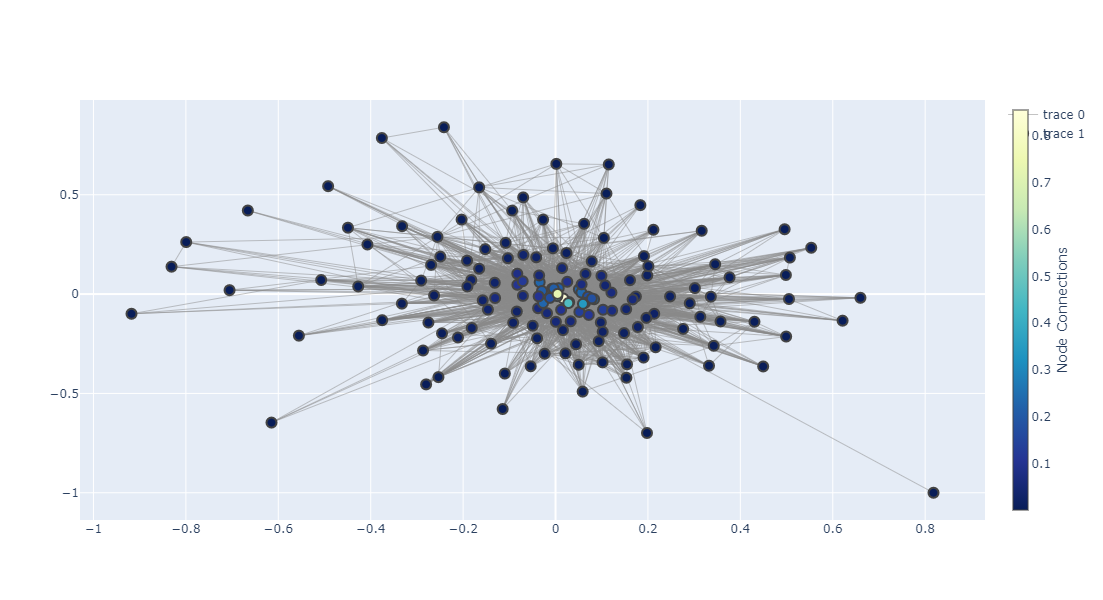

In [4]:
 iplot公司 (无花果 )

In [5]:
无花果=去 .图 (数据= [边缘_痕迹 ,节点_跟踪 ] ,布局=去 .布局 (
宽度= eight thousand , #Set the graphic width to 800 pixels
高度= six thousand #Set the graphic height to 600 pixels
标题= &#39;Relationship Network Diagram of Dream of Red Mansions&#39; , 标题字体= 字典 (大小= sixteen ) ,
 显示图例=False（错误） , 悬停模式=“最近的” ,
边缘= 字典 (b条= twenty ,我= five ,第页= five ,t吨= forty ) ,
注释= [ 字典 (
文本= &#34;Building data analysis and mining practice&#34; , 显示箭头=False（错误） ,
xcre意味著称=“纸张” , yref公司=“纸张” ,x个= zero point zero zero five ,年= - zero point zero zero two ) ] ,
 X轴= 字典 ( 显示网格=False（错误） , 赤霉烯酮=False（错误） ,
 显示记号标签=False（错误） ) ,
 对= 字典 ( 显示网格=False（错误） , 赤霉烯酮=False（错误） , 显示记号标签=False（错误） ) ) )
 iplot公司 (无花果 )

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3882124740.py, line 3)

In [6]:
无花果=去 .图 (数据= [边缘_痕迹 ,节点_跟踪 ] ,布局=去 .布局 (
宽度= eight thousand ,
高度= six thousand ，
标题= &#39;Relationship Network Diagram of Dream of Red Mansions&#39; , 标题字体= 字典 (大小= sixteen ) ,
 显示图例=False（错误） , 悬停模式=“最近的” ,
边缘= 字典 (b条= twenty ,我= five ,第页= five ,t吨= forty ) ,
注释= [ 字典 (
文本= &#34;Building data analysis and mining practice&#34; , 显示箭头=False（错误） ,
xcre意味著称=“纸张” , yref公司=“纸张” ,x个= zero point zero zero five ,年= - zero point zero zero two ) ] ,
 X轴= 字典 ( 显示网格=False（错误） , 赤霉烯酮=False（错误） ,
 显示记号标签=False（错误） ) ,
 对= 字典 ( 显示网格=False（错误） , 赤霉烯酮=False（错误） , 显示记号标签=False（错误） ) ) )
 iplot公司 (无花果 )

SyntaxError: invalid decimal literal (2745313149.py, line 3)

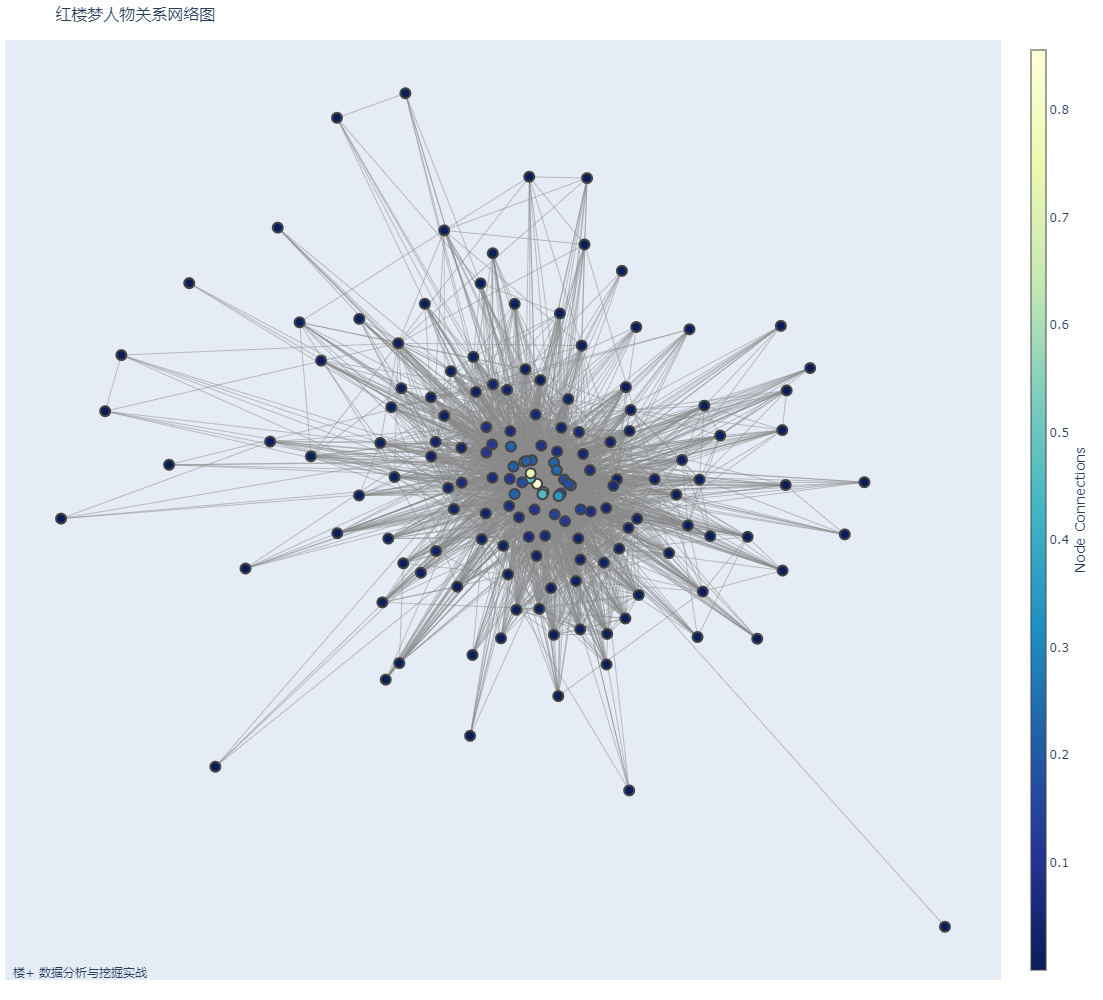

In [7]:
无花果=去 .图 (数据= [边缘_痕迹 ,节点_跟踪 ] ,布局=去 .布局 (
宽度= three thousand ,
高度= one thousand ,
标题= &#39;Relationship Network Diagram of Dream of Red Mansions&#39; , 标题字体= 字典 (大小= sixteen ) ,
 显示图例=False（错误） , 悬停模式=“最近的” ,
边缘= 字典 (b条= twenty ,我= five ,第页= five ,t吨= forty ) ,
注释= [ 字典 (
文本= &#34;Building data analysis and mining practice&#34; , 显示箭头=False（错误） ,
xcre意味著称=“纸张” , yref公司=“纸张” ,x个= zero point zero zero five ,年= - zero point zero zero two ) ] ,
 X轴= 字典 ( 显示网格=False（错误） , 赤霉烯酮=False（错误） ,
 显示记号标签=False（错误） ) ,
 对= 字典 ( 显示网格=False（错误） , 赤霉烯酮=False（错误） , 显示记号标签=False（错误） ) ) )
 iplot公司 (无花果 )

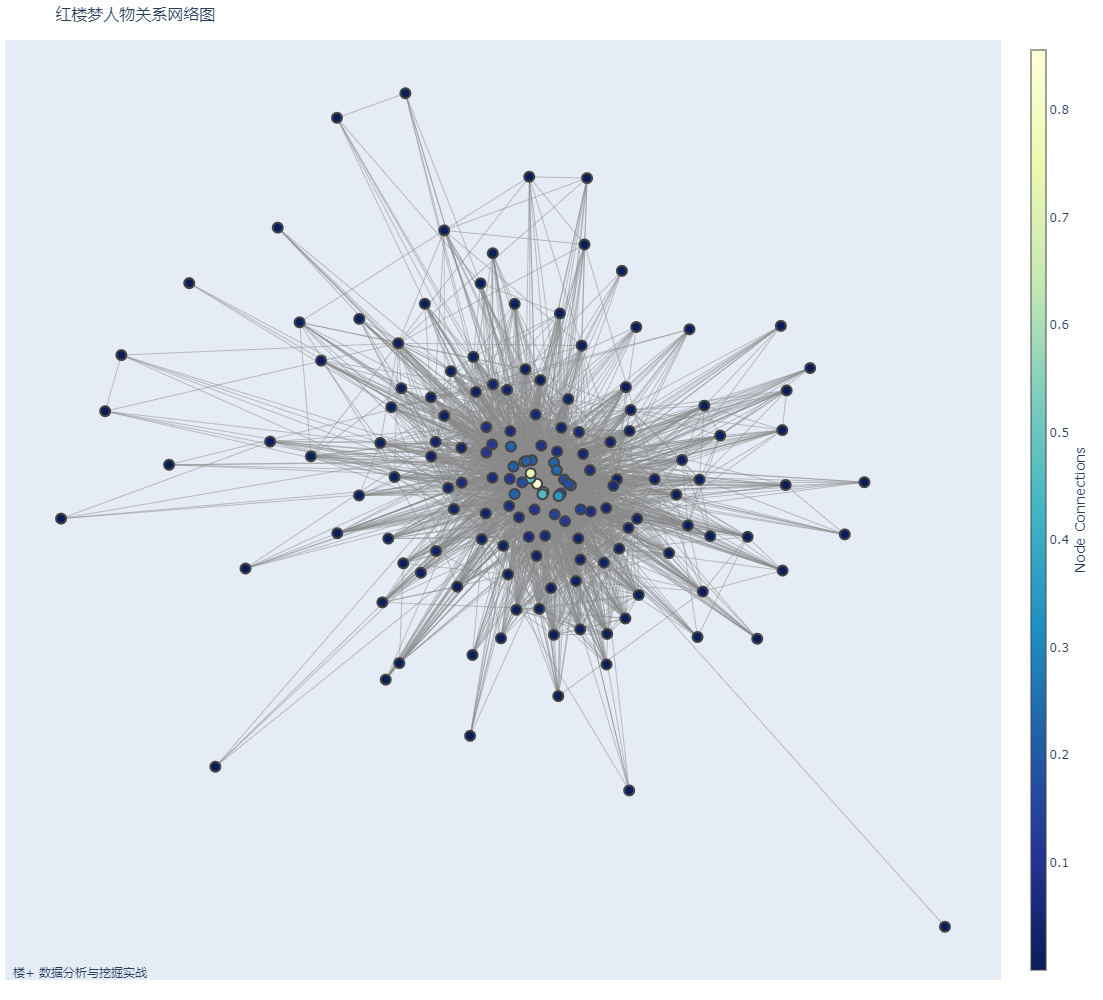

In [8]:
无花果=去 .图 (数据= [边缘_痕迹 ,节点_跟踪 ] ,布局=去 .布局 (
宽度= one thousand ,
高度= one thousand ,
标题= &#39;Relationship Network Diagram of Dream of Red Mansions&#39; , 标题字体= 字典 (大小= sixteen ) ,
 显示图例=False（错误） , 悬停模式=“最近的” ,
边缘= 字典 (b条= twenty ,我= five ,第页= five ,t吨= forty ) ,
注释= [ 字典 (
文本= &#34;Building data analysis and mining practice&#34; , 显示箭头=False（错误） ,
xcre意味著称=“纸张” , yref公司=“纸张” ,x个= zero point zero zero five ,年= - zero point zero zero two ) ] ,
 X轴= 字典 ( 显示网格=False（错误） , 赤霉烯酮=False（错误） ,
 显示记号标签=False（错误） ) ,
 对= 字典 ( 显示网格=False（错误） , 赤霉烯酮=False（错误） , 显示记号标签=False（错误） ) ) )
 iplot公司 (无花果 )